# Section order

Here we analyze document similarity/difference from one another based on the degree of shared order of sections within a document. Sections are defined in 03_define_sections_R. 

Our approach is based on the idea of *synteny* from the field of genomics. Two (or more) genes are said to have a synteny if those genes are found in proximity across a set of genomes. The degree of synteny is proportional to the frequency with which genes are colocalized and the evolutionary distance of organisms in which that colocalization occurs.  

A genome wide *synteny index* between a pair of genomes can be defined by calculating the *synteny* for all gene shared between that genome pair.

Reference: ~/resources/biology/gene-order-phylogenetics/Ordered-orthology-as-a-tool-in-prokaryotic-evolutionary-inference.pdf

For this analysis, **genes** are equivalent to **sections** (not **entries**) and **genomes** are equivalent to **documents**.  

### Limitations/Issues: 
- SI is only defined for sections shared between two documents. If there is no overlap in sections, the genome-wide SI is 0. Short documents will tend to have extremes of SI, either 1 (all sections shared) or 0 (no sections shared). 
    - That's ok and makes sense.
- Need to set a reasonable value for `k` by trial and error. This may also depend on the distribution of document lengths across our corpus. 
    - Try 2,3,5 or 7 and see what makes sense.
- This method was developed for microbial genomes, which are usually circular. For our purposes, we will need to decide how to treat sections that occur within `k` of the beginning or end of a document.
    - Idea: add a section called "top" and one called "bottom" when known to a document. Treat these as sections in the SI calculations.
- Is the document wide SI the average of all shared sections SIs or are non-shared sections counted? 
    - Answer: Don't count non-shared sections.
    - All of our documents are broken. Usually don't know whether a section was originally present in the non-broken document. (Difference because something missing because of sample and something truly missing.) 
- When a section appears multiple times in a document, how to deal with this? (Analogy in genomics is repeated genes.)
    - How common is this? 
- When two sections are flipped in order, this method wouldn't notice (unless the documents are relatively long compared to k). Do we want it to?
- Throw in a handful of outliers (documents from other list types).

### Steps: 
- Determine order of sections within each document in corpus.  
- Provisionally set `k` to some low number (2?).
- For each document pair:
    - Define the union of sections present in that pair.
    - For each section in the union, count the number of shared sections in the k-neighborhood between the two documents.
- Calculate document wide SI = average SI for all sections present in both documents (don't include unshared sections in calculation).
- Distance = 1 - document wide SI for any document pair
- Calculate a tree from the distance matrix



## Read in section definitions
Sections were defined in (previous notebook link) and are read in from file here.

In [1]:
setwd("../data/sections/")

Q1_sections = read.csv("Q01_sections.csv", stringsAsFactors = FALSE)
Q39_sections = read.csv("Q39_sections.csv", stringsAsFactors = FALSE)
Q40_sections = read.csv("Q40_sections.csv", stringsAsFactors = FALSE)
Q41_sections = read.csv("Q41_sections.csv", stringsAsFactors = FALSE)
Q42_sections = read.csv("Q42_sections.csv", stringsAsFactors = FALSE)

## Read in a corpus to analyze

In [33]:
df = read.csv("../pass/Q39_par.csv", stringsAsFactors = FALSE)
tail(df)
length(unique(df$id_text))

X    id_line    label lemma                    base                 
7443 7442 X100003.28 r 12  peš[fig]N Subir[1]GN     {ŋeš}peš₃ su-bir{ki} 
7444 7443 X100003.29 r 13  peš[fig]N Elam[1]GN      {ŋeš}peš₃ elam-ma{ki}
7445 7444 X100003.30 r 14  peš[fig]N Martu[1]GN     {ŋeš}peš₃ mar-tu{ki} 
7446 7445 X100003.31 r 15  peš[fig]N šergu[string]N {ŋeš}peš₃ še-er-kum  
7447 7446 X100003.32 r 16  ama[mother]N peš[fig]N   {ŋeš}ama {ŋeš}peš₃   
7448 7447 X100003.33 r 17  pa[branch]N peš[fig]N    {ŋeš}pa {ŋeš}peš₃    
     id_text line skip entry                   
7443 X100003 28   0    peš[fig]N_Subir[1]GN    
7444 X100003 29   0    peš[fig]N_Elam[1]GN     
7445 X100003 30   0    peš[fig]N_Martu[1]GN    
7446 X100003 31   0    peš[fig]N_šergu[string]N
7447 X100003 32   0    ama[mother]N_peš[fig]N  
7448 X100003 33   0    pa[branch]N_peš[fig]N

[1] 136

### Step 1: Determine order of sections for each document in corpus
For each entry in each document in the corpus, identify which section it belongs to. Add this section identification to a new column in the dataframe. If an entry is found in more than one section, section names are separated by ":".

In [3]:
section_defs = Q39_sections
for (i in 1:nrow(df)) {
    entry = tolower(df$entry[i])
    sections = names(which(sapply(section_defs, function(x) any(x == entry)) == TRUE))
    if (length(sections) == 0) df$section[i] = NA
    else df$section[i] = paste(sections, collapse = ":")
}
df

X    id_line    label lemma                                
1     0   P117395.2  o 1   ŋešed[key]N                          
2     1   P117395.3  o 2   pakud[~tree]N                        
3     2   P117395.4  o 3   raba[clamp]N                         
4     3   P117404.2  o 1   ig[door]N eren[cedar]N               
5     4   P117404.3  o 2   ig[door]N dib[board]N                
6     5   P117404.4  o 3   ig[door]N i[oil]N                    
7     6   P128345.2  o 1   garig[comb]N siki[hair]N             
8     7   P128345.3  o 2   garig[comb]N siki-siki[NA]NA         
9     8   P128345.4  o 3   garig[comb]N saŋdu[head]N            
10    9   P224980.4  o i 1 gigir[chariot]N                      
11   10   P224980.5  o i 2 e[house]N gigir[chariot]N            
12   11   P224980.6  o i 3 e[house]N usan[whip]N gigir[chariot]N
13   12   P224986.4  o i 1 guza[chair]N anše[equid]N            
14   13   P224986.5  o i 2 guza[chair]N kaskal[way]N            
15   14   P224986.6  o i 3 guza[chair]N zir[break]V/t           
16   15   P224994.4  o i 1 {ŋeš}x-x[NA]NA                       
17   16   P224994.5  o i 2 {ŋeš}SI-x[NA]NA                      
18   17   P224994.6  o i 3 {ŋeš}šu-x[NA]NA                      
19   18   P224996.4  o i 1 guza[chair]N                         
20   19   P224996.5  o i 2 guza[chair]N gid[long]V/i            
21   20   P224996.6  o i 3 guza[chair]N sirda[cnne]N            
22   21   P225006.4  o i 1 ig[door]N                            
23   22   P225006.5  o i 2 suku[pole]N ig[door]N                
24   23   P225006.6  o i 3 zara[pivot]N ig[door]N               
25   24   P225023.4  o i 1 {ŋeš}x[NA]NA                         
26   25   P225023.5  o i 2 emerah[jug]N x[NA]NA                 
27   26   P225023.6  o i 3 emerah[jug]N x[NA]NA                 
28   27   P225033.4  o i 1 targul[pole]N                        
29   28   P225033.5  o i 2 targul[pole]N                        
30   29   P225033.6  o i 3 garig[comb]N                         
⋮    ⋮    ⋮          ⋮     ⋮                                    
7419 7418 X100003.3  o 2   esi[tree]N                           
7420 7419 X100003.4  o 3   ŋešnu[tree]N                         
7421 7420 X100003.5  o 4   halub[tree]N                         
7422 7421 X100003.6  o 5   šagkal[tree]N                        
7423 7422 X100003.7  o 6   ŋešgana[tree]N                       
7424 7423 X100003.8  o 7   ŋešgana[tree]N babbar[white]V/i      
7425 7424 X100003.9  o 8   ŋešgana[tree]N giggi[black]V/i       
7426 7425 X100003.10 o 9   ŋešgana[tree]N si[fill]V/t           
7427 7426 X100003.11 o 10  {ŋeš}bar-ŋeš[NA]NA gunu[speckled]V/i 
7428 7427 X100003.12 o 11  ŋeš[tree]N babbar[white]V/i          
7429 7428 X100003.13 o 12  ŋeš[tree]N giggi[black]V/i           
7430 7429 X100003.14 o 13  ŋeštin[vine]N                        
7431 7430 X100003.15 o 14  ŋeštinkira[berry]N                   
7432 7431 X100003.17 r 1   ŋeštinzug[grape]N                    
7433 7432 X100003.18 r 2   ŋeštinkaʾa[grape]N                   
7434 7433 X100003.19 r 3   ŋeštin[vine]N garan[bunch]N          
7435 7434 X100003.20 r 4   ŋeštinguruma[~vine]N                 
7436 7435 X100003.21 r 5   ŋeštin[vine]N sur[press]V/t          
7437 7436 X100003.22 r 6   ŋeštin[vine]N igi[eye]N gud[ox]N     
7438 7437 X100003.23 r 7   tila[grapevine]N ŋeštin[vine]N       
7439 7438 X100003.24 r 8   gurum[bend]V/t ŋeštin[vine]N         
7440 7439 X100003.25 r 9   garan[bunch]N ŋeštin[vine]N          
7441 7440 X100003.26 r 10  peš[fig]N                            
7442 7441 X100003.27 r 11  peš[fig]N Mari[1]SN                  
7443 7442 X100003.28 r 12  peš[fig]N Subir[1]GN                 
7444 7443 X100003.29 r 13  peš[fig]N Elam[1]GN                  
7445 7444 X100003.30 r 14  peš[fig]N Martu[1]GN                 
7446 7445 X100003.31 r 15  peš[fig]N šergu[string]N             
7447 7446 X100003.32 r 16  ama[mother]N peš[fig]N               
7448 7447 X100003.33 r 17  pa[branch]N p

Many entries will not be assigned to a section because they either do not appear verbatium in the Q text that was used to define sections or they do appear in the Q text, but were not part of a section (i.e. they were not adjacent to another entry that shared enough similarity to be considered part of the same section).

Very few entries were assigned to more than one section. Only the entry "ŋešgana[pestle]N" appears in two sections in the Q39 corpus. This entry appears in several documents.

In [29]:
unique(df[grep(":", df$section),]$entry)

[1] "ŋešgana[pestle]N"

Now that we know which section(s) each entry belongs to, we can define the order of sections for each document. 

First, we split our dataframe by id_text so that each document is in its own dataframe. We then have a list of dataframes.

We then extract the "section" column from each of those dataframes. This gives us a list of character vectors.

In [31]:
df$id_text = as.factor(df$id_text)
docs = split(df, df$id_text)
docs = sapply(docs, function(x) x$section)
head(docs)

$P117395
[1] NA NA NA

$P117404
[1] NA     "door" "door"

$P128345
[1] "comb" NA     "comb"

$P224980
[1] "chariot" "chariot" "chariot"

$P224986
[1] "chair" "chair" NA     

$P224994
[1] NA NA NA

We need to get rid of `NA`s. These represent entries that were not assigned to a section. Then we retain only documents that are not of length zero (i.e. documents that had at least one entry assigned to a section).

In [7]:
docs_no_nas = sapply(docs, function(x) x[!is.na(x)])

non_empty_docs = sapply(docs_no_nas, function(x) length(x) > 0)

docs_no_nas = docs_no_nas[non_empty_docs]
head(docs_no_nas)

$P117404
[1] "door" "door"

$P128345
[1] "comb" "comb"

$P224980
[1] "chariot" "chariot" "chariot"

$P224986
[1] "chair" "chair"

$P224996
[1] "chair" "chair" "chair"

$P225006
[1] "door" "door"

In [8]:
print(paste("This leaves us with", length(docs_no_nas), "documents."))

[1] "This leaves us with 122 documents."


We can then use the `rle()` function ("run length encoding") to get a character vector of the sections in each document, in order. This function calculates the lengths and values of runs in a sequence. We're not interested in the lengths of the runs (for this analysis), but can extract the values (names of sections).

We end up with a list of character vectors.

In [16]:
doc_sections = lapply(docs_no_nas, 
                      function(x) unname(rle(unlist(x))$values))

In [17]:
head(doc_sections)
tail(doc_sections)

$P117404
[1] "door"

$P128345
[1] "comb"

$P224980
[1] "chariot"

$P224986
[1] "chair"

$P224996
[1] "chair"

$P225006
[1] "door"

$P459228
[1] "nut"

$P459231
[1] "chariot"

$P459784
[1] "X.6"    "tree.1"

$P492330
[1] "bolt" "X.6" 

$Q000039
  [1] "tree"           "apple"          "tree.1"         "tamarisk"      
  [5] "tree.2"         "plum"           "nut"            "poplar"        
  [9] "wood.1"         "tree.3"         "wood"           "twig"          
 [13] "tree.4"         "cedar"          "poplar.1"       "flower"        
 [17] "tree.5"         "sprout"         "poplar.1"       "acacia"        
 [21] "tree.6"         "X"              "foliage_sky"    "branch"        
 [25] "trough"         "X.1"            "X.2"            "X.2:mortar"    
 [29] "X.2"            "tool"           "X.3"            "chair"         
 [33] "stool"          "bed"            "dish"           "table"         
 [37] "jug"            "stair"          "planking_stair" "trough"        
 [41] "mortar"         "X.2:mortar"     "plank"          "ship"          
 [45] "ship_fisherman" "X1"             "X1.1"           "horn_ship"     
 [49] "boat"           "pole"           "rudder"         "rope"          
 [53] "staff"          "chariot"        "whip"           "harness"       
 [57] "vehicle_place"  "door"           "door.1"         "bolt"          
 [61] "tube"           "loom"           "loom.1"         "comb"          
 [65] "spindle"        "pole.1"         "rim"            "scales"        
 [69] "plow"           "harrow"         "tool.1"         "hoe"           
 [73] "brick.mold"     "nail_mound_dig" "weapon"         "board"         
 [77] "unit"           "net"            "snare"          "trap"          
 [81] "youth_praise"   "sign"           "thorn"          "lance"         
 [85] "weapon.1"       "bow"            "trap.1"         "weapon.2"      
 [89] "ax"             "ax.1"           "fork"           "moon"          
 [93] "shovel"         "rot"            "hook"           "instrument"    
 [97] "X.4"            "post_bed"       "lyre"           "instrument.1"  
[101] "handle"         "bench"          "ram"            "weapon.3"      
[105] "beam"           "rudder.1"       "crook"          "forest_die"    
[109] "seed.funnel"    "wood.1"         "tree"           "X.5"           
[113] "weed"           "staff.1"        "X.6"            "board.1"       
[117] "sign_eat"       "doll"          

$X100003
[1] "tree"

### Question for Niek:

What is the "X-" document? What makes it different from the "P-" documents?

Most documents have fewer than 5 sections. Eighteen documents have 20 sections or more. Twenty-two have 10 sections or more. 

[1] 18

[1] "P235262" "P247864" "P250364" "P253228" "P253233" "P253866" "P271301"
 [8] "P271771" "P271911" "P273880" "P332934" "P346714" "P347814" "P370399"
[15] "P388265" "P429503" "P437074" "P447996" "P459216" "P459217" "P459218"
[22] "Q000039"

[1] 22

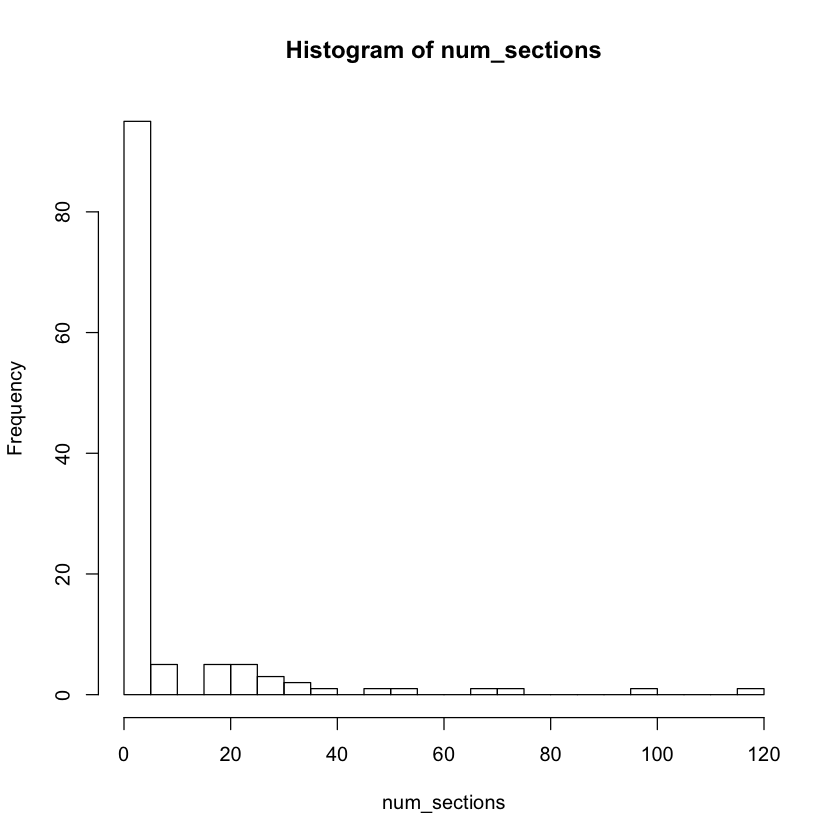

In [38]:
num_sections = sapply(doc_sections, length)
hist(num_sections, breaks = 20)
length(which(num_sections >= 20))
names(which(num_sections >= 10))
length(which(num_sections >= 10))

To Do: We want to add a "top" and "bottom" section to each document, but I think we need to do this earlier in the process, since we need to know whether the information we have is actually the top and bottom of the document and we've already discarded information about skipped lines and missing pieces at this point.

Notes:  
1) SI for shared sections will always be at least one because the section appears in its own k neighborhood. Do we want it this way?  
2) When a section appears more than once in a document, do we want the k-neighborhood to be the intersection of all k-neighborhoods for that section?

### Method 1: Repeated sections combined

This method considers repeated sections in a document as a single section and combines their k-neighborhoods.

First, we need a function to get the section neighborhood for any given section in any given document. The function below accomplishes this. Note that it is agnostic to the number of times a section appears in a document, combining the neighborhoods for all times that section appears. Individual neighborhoods are "neighborhood", combined neighborhoods are "n". 

Note also that the complicated indexing within the for loop is required to avoid going out of bounds. This is important for first few and last few sections in a document. Going out of bounds into negative numbers will throw a `Traceback error`, however, going out of bounds into numbers larger than the length of the vector you're indexing will add `NA`s to your resulting vector. This is worse because the `NA`s are counted in the intersection!

Another thing to notice is that the grep statement only finds whole word matches. This is accomplished by using the "beginning of string" `^` and "end of string" `$` metacharacters within the regular expression search.

In [113]:
get_neighborhood = function(doc, i) {
    
    # create vector to store combined neighborhoods
    n = c()
    
    # search for a section within a document and extract neighborhood
    for(x in grep(paste0("^",i,"$"), doc)) {
    
        if(x >= k+1 & x <= length(doc) - k) sequence = (x - k):(x + k)
        else if(x < k+1) sequence = 1:(x + k)
        else if(x > length(doc) - k) sequence = (x - k):length(doc)
    
        neighborhood = doc[sequence]
    
        # add neighborhood to combined neighborhoods for repeated sections
        n = c(n, neighborhood)
}
        # return combined neighborhood    
        print(n) 
    }

Our next step is to create a function to calculate a document-wide synteny index (SI) for any given document pair. 

In [117]:
#A = doc_sections[["P235262"]]
#B = doc_sections[["P247864"]]

calc_SI = function(A, B, k) {

    I = intersect(A, B)
    print(I)
    counter = 0

    for(i in I) {
        print(i)
        n_A = get_neighborhood(A, i)
        n_B = get_neighborhood(B, i)
        SI = length(na.omit(intersect(n_A, n_B)))
        print(SI)
        counter = counter + SI
        }

return(counter/length(I))
    
    }

#test = calc_SI(A, B, k = 2)
#test

Now we will create a dataframe to store our results. It will have column `doc_A` = text_id for first document in compared pair, column `doc_B` = text_id for second document in compared pair, `num_shared_sec` = length(I) or number of shared sections between the two documents, and `SI` = document wide SI. 

The function `combn` allows us to get all possible combinations of documents. `t` transposes the resulting data.frame.

In [158]:
docs = names(doc_sections)
all_pairs = t(as.data.frame(combn(docs, 2)))

all_pairs_SI = data.frame("doc_A" = all_pairs[,1], "doc_B" = all_pairs[,2], 
                        "num_shared_sec" = numeric(length(all_pairs)), 
                       "SI" = numeric(length(all_pairs)))
all_pairs_SI$doc_A = as.character(all_pairs_SI$doc_A)
all_pairs_SI$doc_B = as.character(all_pairs_SI$doc_B)

str(all_pairs_SI)

Warning message in data.frame(doc_A = all_pairs[, 1], doc_B = all_pairs[, 2], num_shared_sec = numeric(length(all_pairs)), :
“row names were found from a short variable and have been discarded”

'data.frame':	14762 obs. of  4 variables:
 $ doc_A         : chr  "P117404" "P117404" "P117404" "P117404" ...
 $ doc_B         : chr  "P128345" "P224980" "P224986" "P224996" ...
 $ num_shared_sec: num  0 0 0 0 0 0 0 0 0 0 ...
 $ SI            : num  0 0 0 0 0 0 0 0 0 0 ...


Now we use the `calc_SI` function to iterate through each of the document pairs and store the results in our data.frame `all_pairs_SI`.

In [177]:
for(i in 1:nrow(all_pairs_SI)) {
    A = all_pairs_SI[i,]$doc_A
    B = all_pairs_SI[i,]$doc_B
    all_pairs_SI[i,]$SI = 
        calc_SI(doc_sections[[A]], doc_sections[[B]], k = 2)
}

character(0)
character(0)
character(0)
character(0)
[1] "door"
[1] "door"
[1] "door" NA     NA    
[1] "door" NA     NA    
[1] 1
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
[1] "door"
[1] "door"
[1] "door" NA     NA    
[1] "comb"    "spindle" "door"    "handle"  "plank"  
[1] 1
character(0)
character(0)
character(0)
character(0)
[1] "door"
[1] "door"
[1] "door" NA     NA    
[1] "door" "bolt" "X.6" 
[1] 1
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
[1] "door"
[1] "door"
[1] "door" NA     NA    
[1] "loom.1" "loom"   "door"   "staff"  "stool" 
[1] 1
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0)
character(0

doc_A   doc_B   num_shared_sec SI 
14757 P459784 P492330 0                1
14758 P459784 Q000039 0                1
14759 P459784 X100003 0              NaN
14760 P492330 Q000039 0                1
14761 P492330 X100003 0              NaN
14762 Q000039 X100003 0                1

In [180]:
summary(all_pairs_SI$SI)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   1.000   1.000   1.222   1.000   4.333   11508 

In [ ]:
# Niek's method (consider each instance of a repeated section independently)

A = doc_sections[[24]]
B = doc_sections[[58]]

I = intersect(A, B)

l = list()
j = 1

# create a list storing section matching information
for(i in I) {
    index_A = grep(paste0("^",i,"$"), A)
    index_B = grep(paste0("^",i,"$"), B)
    section_indices = list(section = i, index_A = index_A, index_B = index_B)
    l[[j]] = section_indices
    j = j + 1
    }


### Update to use method above
counter = 0
k = 2

for(x in grep(i, A)) {
    neighborhood_A = A[(x - k):(x + k)]
    n_A = c(n_A, neighborhood_A)
}

for(x in grep(i, B)) {
    neighborhood_B = B[(x - k):(x + k)]
    n_B = c(n_B, neighborhood_B)
}

SI = length(na.omit(intersect(n_A, n_B)))
SI


In [115]:
test

[1] 1.923077